## 7.2 使用块的网络(VGG)

### 7.2.1 VGG块

经典卷积神经网络的基本组成部分是下面的这个序列：

1. 带填充以保持分辨率的卷积层；
2. 非线性激活函数，如ReLU；
3. 汇聚层，如最大汇聚层。

在最初的VGG论文中，VGG块中的部分是$3\times 3$的卷积核和1填充的卷积层、$2\times 2$的汇聚窗口和2步幅的最大汇聚层。

下面定义了一个VGG块。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        # 这里只有第一个卷积层的输入输出通道可能不一致，后续都是一致的
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

### 7.2.2 VGG网络

由两个部分组成，一个是VGG块，一个是全连接层。如下图所示。

![](../images/7-2-1.svg)

原始的VGG网络有5个卷积块，其两个块各有一个卷积层，后三个块有两个卷积层，故被称为VGG-11，下面实现了VGG-11

In [2]:
# (卷积层个数, 输出通道数)
conv_arch = (
    (1, 64),
    (1, 128),
    (2, 256),
    (2, 512),
    (2, 512),
)

In [3]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    return nn.Sequential(
        *conv_blks,
        nn.Flatten(),
        nn.Linear(out_channels*7*7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10),
    )

net = vgg(conv_arch)

In [4]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 7.2.3 训练模型

构建了一个通道数较少的网络以减轻计算量

In [5]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

除了使用略高的学习率外，其余于[7.1节](7-1.ipynb)中一致

loss 0.146, train acc 0.946, test acc 0.916
2639.8 examples/sec on cuda:0


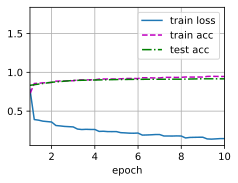

In [6]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 7.2.4 小结

- VGG-11使用可复用的卷积块构造网络。不同的VGG模型可通过每个块中卷积层数量和输出通道数量的差异来定义。
- 块的使用导致网络定义的非常简洁。使用块可以有效地设计复杂的网络。
- 在VGG论文中，Simonyan和Ziserman尝试了各种架构。特别是他们发现深层且窄的卷积（即$3\times 3$）比较浅层且宽的卷积更有效。